In [16]:
import os
import numpy as np
import requests
from zipfile import ZipFile
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
from itertools import product
import time
!pip install kaggle
!pip3 install ann_visualizer
!pip install graphviz
from ann_visualizer.visualize import ann_viz
from graphviz import Source

In [17]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"janwojdylak","key":"39ad2ce3d50e08dcd9d8e4ba4feecea8"}'}

In [18]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [19]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [20]:
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification
!unzip muffin-vs-chihuahua-image-classification.zip -d /content/dataset

In [36]:
def load_dataset():
    x = []
    y = []
    classes = ['chihuahua', 'muffin']
    dataset_path = '/content/dataset'

    # Load training images and labels
    for class_name in classes:
        class_path = os.path.join(dataset_path, 'train', class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (32, 32))
            x.append(img)
            y.append(classes.index(class_name))

    # Load testing images and labels
    for class_name in classes:
        class_path = os.path.join(dataset_path, 'test', class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (32, 32))
            x.append(img)
            y.append(classes.index(class_name))

    x = np.array(x)
    y = np.array(y)

    return x,y

In [26]:
# Load the dataset
x,y = load_dataset()


In [32]:
# Normalize the pixel values between 0 and 1
x = x / 255.0
print(x[0])

# Convert the labels to one-hot encoding
num_classes = 2
y = np.eye(num_classes)[y]


[[[0.91372549 0.9254902  0.96078431]
  [0.84705882 0.89803922 0.92156863]
  [0.78431373 0.83529412 0.85882353]
  ...
  [0.3372549  0.32941176 0.23921569]
  [0.60784314 0.62745098 0.63921569]
  [0.79215686 0.80784314 0.92156863]]

 [[0.8745098  0.92941176 0.97254902]
  [0.83529412 0.88627451 0.90980392]
  [0.58431373 0.67058824 0.48235294]
  ...
  [0.24313725 0.21568627 0.15686275]
  [0.56078431 0.54117647 0.5254902 ]
  [0.7372549  0.76078431 0.83137255]]

 [[0.83921569 0.88627451 0.93333333]
  [0.80392157 0.85490196 0.88627451]
  [0.40392157 0.49803922 0.2627451 ]
  ...
  [0.37647059 0.28235294 0.14901961]
  [0.58039216 0.57647059 0.56862745]
  [0.63921569 0.65490196 0.65098039]]

 ...

 [[0.8        0.89019608 0.43529412]
  [0.45490196 0.55294118 0.06666667]
  [0.39607843 0.51764706 0.0627451 ]
  ...
  [0.2        0.29019608 0.07058824]
  [0.35686275 0.47843137 0.21568627]
  [0.3372549  0.42745098 0.20784314]]

 [[0.29411765 0.37647059 0.        ]
  [0.71764706 0.81960784 0.38823529]


In [33]:
# Get basic information about the loaded data
print("Data:")
print("  Number of samples:", len(x))
print("  Data type:", x.dtype)
print("  Data shape:", x.shape)

print("\nTraining Labels:")
print("  Number of labels:", len(y))
print(" Labels: ", y)
print("  Data type:", y.dtype)
print("  Label shape:", y.shape)

Data:
  Number of samples: 5917
  Data type: float64
  Data shape: (5917, 32, 32, 3)

Training Labels:
  Number of labels: 5917
 Labels:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
  Data type: float64
  Label shape: (5917, 2)


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


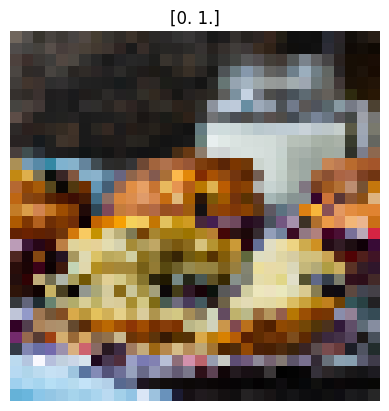

In [34]:
# Select an image index to display
image_index = 4000

# Display the image and label
plt.imshow(x[image_index])
class_index = y[image_index]
plt.title(class_index)
plt.axis("off")
plt.show()

In [27]:
def plot_training_history(history, learning_rate, batch_size, epochs, model):
    # Plot the training loss and accuracy on the same plot
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], 'b',label='Training Loss')
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, [1 - accuracy for accuracy in history.history['val_accuracy']], label='Validation zero - one loss', marker='o', linestyle='-', color='black')

    plt.title('Training and Validation Loss and Accuracy')
    plt.xlabel('Epoch')
    plt.suptitle(f"Number of epochs: { epochs}  Learning rate:  {learning_rate}  Batch size  {batch_size} {model}", ha='center')
    plt.legend()
    plt.show()

In [28]:
def create_model1():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    ann_viz(model, view=True, title="Neural network plot")
    Source.from_file('/content/network.gv')
    return model

In [29]:
def create_model2():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    ann_viz(model, view=True, title="Neural network plot")
    Source.from_file('/content/network.gv')
    return model


In [30]:
def create_model3():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    ann_viz(model, view=True, title="Neural network plot")
    Source.from_file('/content/network.gv')
    return model

In [ ]:
n_splits = 5

hyperparameters = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [16, 64, 128],
    'epochs': [8,16,24],
}

results = []
# Define the K-Fold cross-validation
kfold = KFold(n_splits=5)
fold = 1
cv_accuracy = []
cv_loss = []
cv_zero_one_loss = []
learning_times = []

for hyperparam in product(*hyperparameters.values()):
    hyperparam = dict(zip(hyperparameters.keys(), hyperparam))
    learning_rate = hyperparam['learning_rate']
    batch_size = hyperparam['batch_size']
    epochs = hyperparam['epochs']
    fold = 1
    for train_index, validation_index in kfold.split(x, y):
        # Split the data into training and validation sets
        x_train_fold, x_validation_fold = x[train_index], x[validation_index]
        y_train_fold, y_validation_fold = y[train_index], y[validation_index]

        print(f"Fold: {fold}")
        print("x_train_fold size: ", len(x_train_fold))
        print("x_validation_fold size: ", len(x_validation_fold))
        print("y_train_fold size: ", len(y_train_fold))
        print("y_validation_fold size: ", len(y_validation_fold))

        # Create the model
        model = create_model2()
        model.summary()

        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=['accuracy'])

        # Train the model
        start = time.time()
        history = model.fit(x_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_validation_fold, y_validation_fold))
        end = time.time()
        learning_times.append(end - start) # time in seconds

        plot_training_history(history, learning_rate, batch_size, epochs, "model2")

        validation_loss, validation_accuracy = model.evaluate(x_validation_fold, y_validation_fold, verbose=0)
        validation_zero_one_loss = 1 - validation_accuracy

        cv_accuracy.append(validation_accuracy)
        cv_loss.append(validation_loss)
        cv_zero_one_loss.append(validation_zero_one_loss)

        print("test accuracy:", validation_accuracy)
        print("test loss:", validation_loss)
        print("Zero-One Loss on Test Fold: ",validation_zero_one_loss )

        #get_metrics_resault
        print("get_metrics_result: ", model.get_metrics_result())
        # Store the results
        results.append({
                  'hyperparameters': hyperparam,
                  'val_loss': validation_loss,
                  'val_acc': validation_accuracy,
              })
        fold += 1

    # Compute the average cross-validated results
    mean_cv_accuracy = np.mean(cv_accuracy)
    mean_cv_loss = np.mean(cv_loss)
    mean_cv_zero_one_loss = np.mean(cv_zero_one_loss)
    mean_learning_time = np.mean(learning_times)
    print("Cross-Validated Accuracy:", mean_cv_accuracy)
    print("Cross-Validated Loss:", mean_cv_loss)
    print("mean_cv_zero_one_loss", mean_cv_zero_one_loss)
    print("cv_zero_one_loss", cv_zero_one_loss)
    print("mean_learning_time",mean_learning_time )
    print("learning times",learning_times )
    cv_accuracy.clear()
    cv_loss.clear()
    cv_zero_one_loss.clear()
    learning_times.clear()
print(results)

Fold: 1
x_train_fold size:  4733
x_validation_fold size:  1184
y_train_fold size:  4733
y_validation_fold size:  1184
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 2304)              0         
  